In [7]:
# Cell 1: Import Libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,classification_report, confusion_matrix
from mealpy.swarm_based.PSO import OriginalPSO
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV

# Set random seed for reproducibility
np.random.seed(42)



In [8]:
# 2. Load and Explore Dataset

# Load dataset
df = pd.read_csv("../Datasets/ovariantotal.csv")

# Display basic info
print("Dataset shape:", df.shape)
print("\nFirst 5 rows:")
display(df.head())

print("\nClass distribution:")
print(df['TYPE'].value_counts())


Dataset shape: (349, 50)

First 5 rows:


,AFP,AG,Age,ALB,ALP,ALT,AST,BASO#,BASO%,BUN,...,PCT,PDW,PHOS,PLT,RBC,RDW,TBIL,TP,UA,TYPE
0,3.58,19.36,47,45.4,56,11,24,0.01,0.30,5.35,...,0.09,13.4,1.46,74,2.64,13.7,5.5,73.9,396.4,0
1,34.24,23.98,61,39.9,95,9,13,0.02,0.30,3.21,...,0.30,11.2,1.09,304,4.89,12.7,6.8,72.0,119.2,0
2,1.50,18.40,39,45.4,77,9,18,0.03,0.60,3.80,...,0.13,15.2,0.97,112,4.62,12.0,14.8,77.9,209.2,0
3,2.75,16.60,45,39.2,26,16,17,0.05,0.74,5.27,...,0.25,17.4,1.25,339,4.01,14.6,10.9,66.1,215.6,0
4,2.36,19.97,45,35.0,47,21,27,0.01,0.10,4.89,...,0.28,11.9,0.94,272,4.40,13.4,5.3,66.5,206.0,0



Class distribution:
TYPE
1    178
0    171
Name: count, dtype: int64


In [9]:
#3. Preprocess Data

# Separate features and target
X = df.drop(columns=['TYPE'])
y = df['TYPE']

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42)

print(f"Training set: {X_train.shape}, Test set: {X_test.shape}")


Training set: (279, 49), Test set: (70, 49)


In [10]:
#4. Define Fitness Function

def feature_selection_fitness(solution):
    # Convert continuous solution to binary (threshold at 0.5)
    binary_solution = (np.array(solution) > 0.5).astype(int)
    
    # Penalize if no features are selected
    if np.sum(binary_solution) == 0:
        return 1.0  # Worst possible error
    
    # Select features and evaluate
    selected_X = X_train[:, binary_solution == 1]
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    scores = cross_val_score(model, selected_X, y_train, cv=5, scoring='accuracy')
    
    return 1 - np.mean(scores)  # Return error (to minimize)


In [11]:
#5. Setup PSO Optimization

problem = {
    "fit_func": feature_selection_fitness,  # Fitness function
    "lb": [0] * X_train.shape[1],          # Lower bounds (0 for all features)
    "ub": [1] * X_train.shape[1],          # Upper bounds (1 for all features)
    "minmax": "min",                       # Minimize the fitness
    "log_to": None                         # Disable logging
}

# Initialize PSO
pso_model = OriginalPSO(
    epoch=15,           # Number of iterations
    pop_size=10,        # Population size (number of particles)
    c1=2.0,             # Cognitive factor
    c2=2.0,             # Social factor
    w_min=0.4,          # Minimum inertia weight
    w_max=0.9           # Maximum inertia weight
)


In [12]:
best_position, best_fitness = pso_model.solve(problem)


Selected Features: ['AG', 'Age', 'ALB', 'AST', 'Ca', 'CEA', 'EO#', 'EO%', 'HE4', 'IBIL', 'K', 'LYM#', 'LYM%', 'MCH', 'Menopause', 'MONO#', 'MONO%', 'MPV', 'NEU', 'UA']
Number of Features Selected: 20
Best Error (1 - accuracy): 0.08597402597402604
Final CV Accuracy: 0.914025974025974


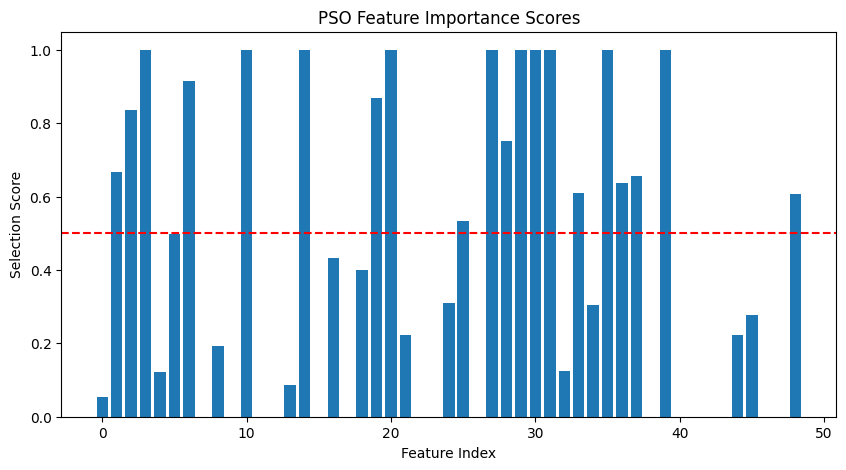

In [13]:
#7. Analyze Results

# Get selected features (binary conversion)
selected_features = (np.array(best_position) > 0.5).astype(int)
selected_indices = np.where(selected_features == 1)[0]
selected_feature_names = X.columns[selected_indices]

print("Selected Features:", list(selected_feature_names))
print("Number of Features Selected:", len(selected_feature_names))
print("Best Error (1 - accuracy):", best_fitness)
print("Final CV Accuracy:", 1 - best_fitness)

# Plot feature importance scores
plt.figure(figsize=(10, 5))
plt.bar(range(len(best_position)), best_position)
plt.axhline(y=0.5, color='r', linestyle='--')
plt.title("PSO Feature Importance Scores")
plt.xlabel("Feature Index")
plt.ylabel("Selection Score")
plt.show()

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Best Hyperparameters: {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 50}
Test Accuracy with Tuned Model: 0.9
Confusion Matrix:
 [[32  4]
 [ 3 31]]
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.89      0.90        36
           1       0.89      0.91      0.90        34

    accuracy                           0.90        70
   macro avg       0.90      0.90      0.90        70
weighted avg       0.90      0.90      0.90        70



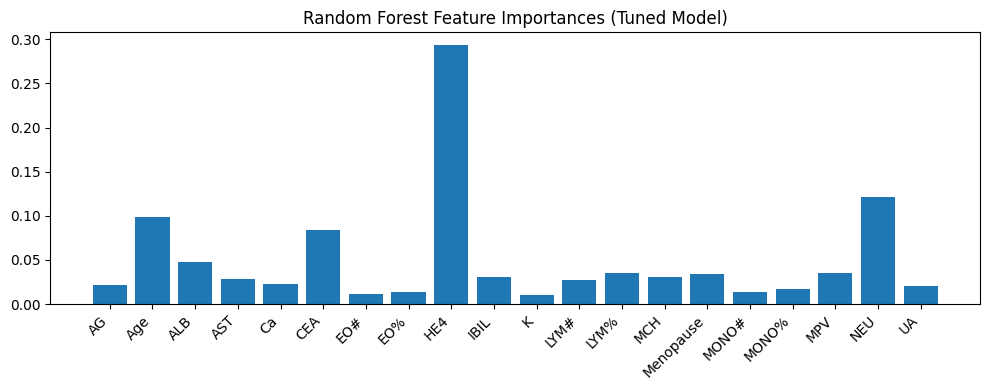

In [14]:
#8. Evaluate on Test Set

# Prepare selected features
X_train_selected = X_train[:, selected_features == 1]
X_test_selected = X_test[:, selected_features == 1]

# Define the hyperparameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}

# Create base model
rf_base = RandomForestClassifier(random_state=42)

# Setup GridSearchCV
grid_search = GridSearchCV(estimator=rf_base,
                           param_grid=param_grid,
                           cv=5,
                           scoring='accuracy',
                           n_jobs=-1,
                           verbose=1)

# Fit the grid search to training data (on selected features)
grid_search.fit(X_train_selected, y_train)

# Get best model
best_model = grid_search.best_estimator_
print("Best Hyperparameters:", grid_search.best_params_)

# Evaluate on test set using the best model
y_pred = best_model.predict(X_test_selected)
test_accuracy = accuracy_score(y_test, y_pred)

print("Test Accuracy with Tuned Model:", test_accuracy)
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Plot feature importances from final tuned model
importances = best_model.feature_importances_
plt.figure(figsize=(10, 4))
plt.bar(selected_feature_names, importances)
plt.xticks(rotation=45, ha="right")
plt.title("Random Forest Feature Importances (Tuned Model)")
plt.tight_layout()
plt.show()
